In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii/online_retail_II.xlsx


One of the biggest ecommerce retailers would like to cut costs while optimising their profits.
They have a huge customer database and they are wondering how they can segment the customers they have and also evaluate their value, what their future transcation rate and profit value is so that they can use marketing resources effectively while cutting costs.

I am going to calculate the below for them:
* Customer Future Transcations in 3 and 6 months
* Customer lifetime value in 6 months
* Recommend to management, 6 months action
* Devide CLV in 4 segments and compare the segments

In [2]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.3 MB/s eta 0:00:00


In [3]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter


In [4]:
data = pd.read_excel('/kaggle/input/online-retail-ii/online_retail_II.xlsx')
df = pd.DataFrame(data)

# DATA WRANGLING AND UNDERSTANDING

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**Description of the columns**
* **Invoice**: invoice number
* **StockCode**: stock id
* **Description**: stock description
* **Quantity**: quantity sold
* **Price**: price point of stock
* **Customer ID**: identity of individual customer that exists in the company
* **country**: customer's residential country

In [7]:
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [8]:
df_nulldropped = df.dropna()
df_nulldropped.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [9]:
df_nulldropped

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


Customer total amount spent in the company

In [10]:
df_nulldropped = df_nulldropped.query('Price>0')

In [11]:
df_nulldropped = df_nulldropped.dropna(subset=['Price'])
total_spent = df_nulldropped.groupby('Customer ID')['Price'].sum().reset_index()
total_spent = total_spent.rename(columns={'Price': 'total amount spent'})
df_nulldropped = df_nulldropped.merge(total_spent, on='Customer ID', how='left')
df_nulldropped

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total amount spent
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1041.17
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1041.17
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1041.17
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1041.17
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1041.17
...,...,...,...,...,...,...,...,...,...
417498,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,415.67
417499,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,415.67
417500,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,415.67
417501,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,415.67


In [12]:
# let's move Customer ID to the first position
column_to_move = 'Customer ID'

# Removing the column and insert it at the first position
col = df_nulldropped.pop(column_to_move)
df_nulldropped.insert(0, column_to_move, col)
df_nulldropped

,Customer ID,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,total amount spent
0,13085.0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,1041.17
1,13085.0,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,1041.17
2,13085.0,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,1041.17
3,13085.0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,1041.17
4,13085.0,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,1041.17
...,...,...,...,...,...,...,...,...,...
417498,17530.0,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,United Kingdom,415.67
417499,17530.0,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,415.67
417500,17530.0,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,415.67
417501,17530.0,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,United Kingdom,415.67


See if I need to convert all date columns into pandas date type

In [13]:
df_nulldropped.dtypes

Customer ID                  float64
Invoice                       object
StockCode                     object
Description                   object
Quantity                       int64
InvoiceDate           datetime64[ns]
Price                        float64
Country                       object
total amount spent           float64
dtype: object

In [14]:
df_nulldropped['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [15]:
df_nulldropped['InvoiceDate'].max()

Timestamp('2010-12-09 20:01:00')

**DEFINING AN OUTLIER THRESHHOLD**

In [16]:
def outlier_thresholds(df, feature, q1=0.05, q3=0.95):
    # Calculate percentiles (Q1 and Q3)
    Q1 = df[feature].quantile(q1)
    Q3 = df[feature].quantile(q3)

    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Determine the outlier cutoffs
    lower_bound = int(round(Q1 - 1.5 * IQR, 0))
    upper_bound = int(round(Q3 + 1.5 * IQR, 0))

    # Identify outlier indices
    outlier_indices = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)].tolist()

    return lower_bound, upper_bound

def replace_with_thresholds(dataframe, variable):
    lower_bound, upper_bound = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < lower_bound), variable] = lower_bound
    dataframe.loc[(dataframe[variable] > upper_bound), variable] = upper_bound

In [17]:
variables = [col for col in df_nulldropped.columns if 'Price' in col]
for variable in variables:
    replace_with_thresholds(df_nulldropped, variable)
variables = [col for col in df_nulldropped.columns if 'total amount spent' in col]
for variable in variables:
    replace_with_thresholds(df_nulldropped, variable)

In [18]:
df_nulldropped

,Customer ID,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,total amount spent
0,13085.0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,1041.17
1,13085.0,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,1041.17
2,13085.0,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,1041.17
3,13085.0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,1041.17
4,13085.0,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,1041.17
...,...,...,...,...,...,...,...,...,...
417498,17530.0,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,United Kingdom,415.67
417499,17530.0,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,415.67
417500,17530.0,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,415.67
417501,17530.0,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,United Kingdom,415.67


# Transforming the transaction data into a frequency, recency, and age dataset

In [19]:
TransformedSummary_To_FRA = summary_data_from_transaction_data(df_nulldropped,'Customer ID','InvoiceDate',observation_period_end='2010-12-09')
TransformedSummary_To_FRA['Customer ID'] = TransformedSummary_To_FRA.index.tolist()
TransformedSummary_To_FRA = TransformedSummary_To_FRA.rename_axis("index")
TransformedSummary_To_FRA['monetary_avg'] =  df_nulldropped['total amount spent']/df_nulldropped['Quantity']
TransformedSummary_To_FRA = TransformedSummary_To_FRA.query('monetary_avg>0')
TransformedSummary_To_FRA = TransformedSummary_To_FRA.query('frequency>0')

# let's move Customer ID to the first position
column_to_move = 'Customer ID'

# Removing the column and insert it at the first position
col = TransformedSummary_To_FRA.pop(column_to_move)
TransformedSummary_To_FRA.insert(0, column_to_move, col)
TransformedSummary_To_FRA.head()

,Customer ID,frequency,recency,T,monetary_avg
index,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000
12347.0,12347.0,1.0,37.0,39.0,11972.000000
12349.0,12349.0,3.0,328.0,370.0,11972.000000
12352.0,12352.0,1.0,17.0,27.0,997.666667
12356.0,12356.0,2.0,44.0,59.0,1995.333333


#  **Establishing BG/NBD, Gamma-Gamma Models and Calculating CLTV**

**Train BG/NBD model**

In [20]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(TransformedSummary_To_FRA['frequency'],
        TransformedSummary_To_FRA['recency'],
        TransformedSummary_To_FRA['T'])


<lifetimes.BetaGeoFitter: fitted with 2831 subjects, a: 0.04, alpha: 87.30, b: 0.56, r: 1.89>

**Number of expected purhases in three months from each customer**

In [21]:
TransformedSummary_To_FRA['expected in 3 months'] = bgf.predict(4*3,
                                                                TransformedSummary_To_FRA['frequency'],
                                                                TransformedSummary_To_FRA['recency'],
                                                                TransformedSummary_To_FRA['T'])
TransformedSummary_To_FRA

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months
index,,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000,0.284103
12347.0,12347.0,1.0,37.0,39.0,11972.000000,0.253593
12349.0,12349.0,3.0,328.0,370.0,11972.000000,0.124974
12352.0,12352.0,1.0,17.0,27.0,997.666667,0.275204
12356.0,12356.0,2.0,44.0,59.0,1995.333333,0.305721
...,...,...,...,...,...,...
18280.0,18280.0,1.0,14.0,29.0,730.010000,0.267075
18283.0,18283.0,4.0,276.0,293.0,730.010000,0.182908
18284.0,18284.0,1.0,2.0,66.0,730.010000,0.166146



**Number of expected purhases in six months from each customer**

In [22]:
TransformedSummary_To_FRA['expected in 6 months'] = bgf.predict(4*6,
                                                                TransformedSummary_To_FRA['frequency'],
                                                                TransformedSummary_To_FRA['recency'],
                                                                TransformedSummary_To_FRA['T'])
TransformedSummary_To_FRA

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months
index,,,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000,0.284103,0.567824
12347.0,12347.0,1.0,37.0,39.0,11972.000000,0.253593,0.505114
12349.0,12349.0,3.0,328.0,370.0,11972.000000,0.124974,0.249733
12352.0,12352.0,1.0,17.0,27.0,997.666667,0.275204,0.547962
12356.0,12356.0,2.0,44.0,59.0,1995.333333,0.305721,0.609707
...,...,...,...,...,...,...,...
18280.0,18280.0,1.0,14.0,29.0,730.010000,0.267075,0.531810
18283.0,18283.0,4.0,276.0,293.0,730.010000,0.182908,0.365470
18284.0,18284.0,1.0,2.0,66.0,730.010000,0.166146,0.331143


In [23]:
TransformedSummary_To_FRA.isna().sum()

Customer ID             0
frequency               0
recency                 0
T                       0
monetary_avg            0
expected in 3 months    0
expected in 6 months    0
dtype: int64

In [24]:
TransformedSummary_To_FRA_nulldropped = TransformedSummary_To_FRA.dropna()
TransformedSummary_To_FRA_nulldropped.isna().sum()

Customer ID             0
frequency               0
recency                 0
T                       0
monetary_avg            0
expected in 3 months    0
expected in 6 months    0
dtype: int64

In [25]:
TransformedSummary_To_FRA_nulldropped

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months
index,,,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000,0.284103,0.567824
12347.0,12347.0,1.0,37.0,39.0,11972.000000,0.253593,0.505114
12349.0,12349.0,3.0,328.0,370.0,11972.000000,0.124974,0.249733
12352.0,12352.0,1.0,17.0,27.0,997.666667,0.275204,0.547962
12356.0,12356.0,2.0,44.0,59.0,1995.333333,0.305721,0.609707
...,...,...,...,...,...,...,...
18280.0,18280.0,1.0,14.0,29.0,730.010000,0.267075,0.531810
18283.0,18283.0,4.0,276.0,293.0,730.010000,0.182908,0.365470
18284.0,18284.0,1.0,2.0,66.0,730.010000,0.166146,0.331143


**Let me validate the model**

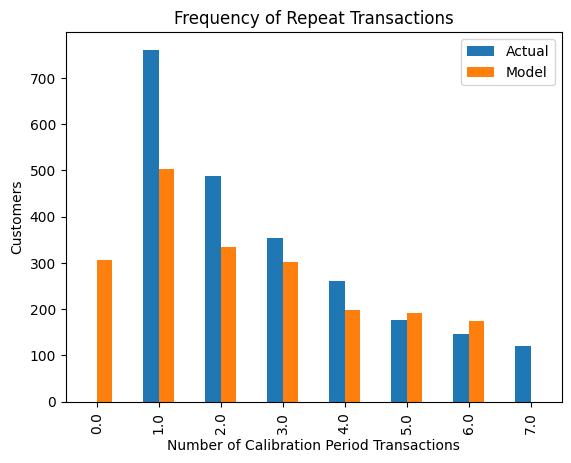

In [26]:
plot_period_transactions(bgf)
plt.show()

**Exploring the FR matrix**

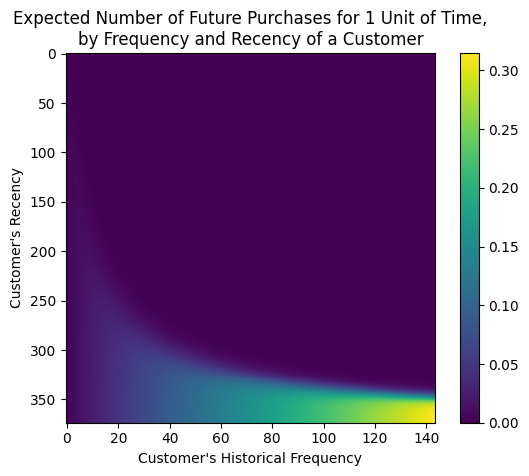

In [27]:
plot_frequency_recency_matrix(bgf)
plt.show()

Any customer who's bought around 123 times and their purchase was when they were 31 weeks old is your best customer

The tail around 50,represents a customer who buys infrequently but we have seen recently, chances ae the might buy again. At the moment we are not sure if they are dead or just between purchases.

**Let me see how different the transcation's are from each other**

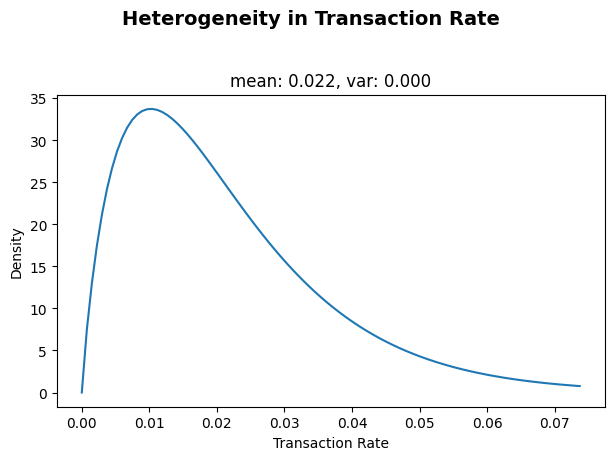

In [28]:
plot_transaction_rate_heterogeneity(bgf)
plt.show()

**Who will be the top 10 best cutomers in three months?**

In [29]:
TransformedSummary_To_FRA_nulldropped.sort_values('expected in 6 months', ascending=False).head(10)

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months
index,,,,,,,
14911.0,14911.0,143.0,373.0,373.0,16.507500,3.774134,7.544203
15311.0,15311.0,114.0,373.0,373.0,5.111250,3.018509,6.033755
12748.0,12748.0,98.0,370.0,370.0,1952.136250,2.618670,5.234481
14156.0,14156.0,98.0,367.0,373.0,9625.220000,2.598600,5.194383
14606.0,14606.0,95.0,370.0,371.0,5681.190000,2.534186,5.065610
14527.0,14527.0,74.0,372.0,372.0,47.605000,1.980563,3.958959
13694.0,13694.0,54.0,362.0,370.0,2.528472,1.462757,2.923889
12471.0,12471.0,52.0,365.0,372.0,127.960000,1.404608,2.807660
16422.0,16422.0,52.0,369.0,373.0,102.823333,1.402338,2.803125


Based on the analysis, the top 10 customers who will make the most purchases in the 3rd and 6th months are the same. These customers have high recency scores, indicating that they have made recent purchases. They also have high frequency scores, suggesting that they make purchases frequently. Their monetary scores are relatively high, indicating that they are high spenders. These customers are expected to bring significant revenue to the company in the coming months.

In [30]:
TransformedSummary_To_FRA_nulldropped[['monetary_avg','frequency']].corr()

,monetary_avg,frequency
monetary_avg,1.000000,-0.006893
frequency,-0.006893,1.000000


GammaGamma model assumes indepency between monetary average and frequency, so in order to use this model I need to ensure that this is true, and looking in the previous, the assumption is proven true and we can move on and use the model.

**I am going to use the GammaGamma model to estimate the average value that the customer is worth in tehe company and add it onto the dataframe**

In [31]:
TransformedSummary_To_FRA_nulldropped = TransformedSummary_To_FRA_nulldropped.query('monetary_avg>0')
gg = GammaGammaFitter(penalizer_coef=0.01)
gg.fit(TransformedSummary_To_FRA_nulldropped['frequency'],
       TransformedSummary_To_FRA_nulldropped['monetary_avg'])
print(gg.summary)

       coef  se(coef)  lower 95% bound  upper 95% bound
p  1.941979  0.065520         1.813559         2.070398
q  0.295823  0.006366         0.283346         0.308300
v  2.456678  0.089124         2.281994         2.631362


The parameters p,q,v represents the gamma distribution and are all within their 95% confidence intervals, which show a good precision of the model

In [32]:
TransformedSummary_To_FRA_nulldropped['exp_avg_value'] = gg.conditional_expected_average_profit(TransformedSummary_To_FRA_nulldropped['frequency'],
                                                                                                   TransformedSummary_To_FRA_nulldropped['monetary_avg'])
TransformedSummary_To_FRA_nulldropped

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months,exp_avg_value
index,,,,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000,0.284103,0.567824,12474.883560
12347.0,12347.0,1.0,37.0,39.0,11972.000000,0.253593,0.505114,18786.650712
12349.0,12349.0,3.0,328.0,370.0,11972.000000,0.124974,0.249733,13618.931019
12352.0,12352.0,1.0,17.0,27.0,997.666667,0.275204,0.547962,1569.087304
12356.0,12356.0,2.0,44.0,59.0,1995.333333,0.305721,0.609707,2438.709783
...,...,...,...,...,...,...,...,...
18280.0,18280.0,1.0,14.0,29.0,730.010000,0.267075,0.531810,1149.162422
18283.0,18283.0,4.0,276.0,293.0,730.010000,0.182908,0.365470,803.459417
18284.0,18284.0,1.0,2.0,66.0,730.010000,0.166146,0.331143,1149.162422


I am going to predict the customer lifetime value in 6 months

In [33]:
TransformedSummary_To_FRA_nulldropped['clv in 6 months'] = gg.customer_lifetime_value(bgf,
                                                                                     TransformedSummary_To_FRA_nulldropped['frequency'],
                                                                                     TransformedSummary_To_FRA_nulldropped['recency'],
                                                                                     TransformedSummary_To_FRA_nulldropped['T'],
                                                                                     TransformedSummary_To_FRA_nulldropped['monetary_avg'],
                                                                                     time = 6,
                                                                                     freq ='W',
                                                                                     discount_rate =0.01)
TransformedSummary_To_FRA_nulldropped.sort_values('clv in 6 months', ascending=False).head(20)

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months,exp_avg_value,clv in 6 months
index,,,,,,,,,
14156.0,14156.0,98.0,367.0,373.0,9625.220000,2.598600,5.194383,9660.991548,52648.746543
14606.0,14606.0,95.0,370.0,371.0,5681.190000,2.534186,5.065610,5702.983742,30308.616409
12720.0,12720.0,10.0,137.0,141.0,15617.090000,0.620879,1.240199,16204.940122,21082.685416
12747.0,12747.0,20.0,363.0,367.0,15617.090000,0.576402,1.152117,15905.587678,19225.398736
12782.0,12782.0,7.0,145.0,154.0,15617.090000,0.437684,0.874256,16470.639425,15105.506400
12708.0,12708.0,13.0,353.0,356.0,15617.090000,0.401367,0.802220,16065.389937,13521.061641
12739.0,12739.0,1.0,9.0,29.0,15617.090000,0.262915,0.523527,24505.409774,13452.390782
14800.0,14800.0,4.0,66.0,70.0,11247.370000,0.442365,0.882825,12369.285312,11453.830103
12721.0,12721.0,3.0,106.0,106.0,15617.090000,0.298167,0.595178,17765.175083,11090.752235


I am now going to segment customers in 4, this way we will have some sort of ranking and distribute resources accordingly

In [34]:
TransformedSummary_To_FRA_nulldropped['clv segment'] = pd.qcut(TransformedSummary_To_FRA_nulldropped['clv in 6 months'], 4, labels=['D', 'C', 'B', 'A'])
TransformedSummary_To_FRA_nulldropped

,Customer ID,frequency,recency,T,monetary_avg,expected in 3 months,expected in 6 months,exp_avg_value,clv in 6 months,clv segment
index,,,,,,,,,,
12346.0,12346.0,9.0,294.0,360.0,11972.000000,0.284103,0.567824,12474.883560,7431.461339,A
12347.0,12347.0,1.0,37.0,39.0,11972.000000,0.253593,0.505114,18786.650712,9950.713515,A
12349.0,12349.0,3.0,328.0,370.0,11972.000000,0.124974,0.249733,13618.931019,3568.054165,A
12352.0,12352.0,1.0,17.0,27.0,997.666667,0.275204,0.547962,1569.087304,901.554840,A
12356.0,12356.0,2.0,44.0,59.0,1995.333333,0.305721,0.609707,2438.709783,1559.449804,A
...,...,...,...,...,...,...,...,...,...,...
18280.0,18280.0,1.0,14.0,29.0,730.010000,0.267075,0.531810,1149.162422,640.820740,A
18283.0,18283.0,4.0,276.0,293.0,730.010000,0.182908,0.365470,803.459417,308.050690,A
18284.0,18284.0,1.0,2.0,66.0,730.010000,0.166146,0.331143,1149.162422,399.069453,A


Below are recommendations to the management for the segments on 6 months action

In [35]:
TransformedSummary_To_FRA_nulldropped_Seg = TransformedSummary_To_FRA_nulldropped.groupby('clv segment').agg({
    'monetary_avg': ['mean', 'sum'],
    'expected in 6 months': ['mean', 'sum'],
    'exp_avg_value': ['mean', 'sum'],
    'clv in 6 months': ['mean', 'sum']
})

TransformedSummary_To_FRA_nulldropped_Seg.sort_values('clv segment', ascending=False)

monetary_avg               expected in 6 months              \
                    mean           sum                 mean         sum   
clv segment                                                               
A            3070.853100  2.174164e+06             0.575356  407.351904   
B             326.480627  2.308218e+05             0.495814  350.540415   
C             111.104102  7.866170e+04             0.413138  292.501663   
D              26.039712  1.843612e+04             0.316632  224.175665   

            exp_avg_value               clv in 6 months                
                     mean           sum            mean           sum  
clv segment                                                            
A             3792.194262  2.684874e+06     1751.785707  1.240264e+06  
B              416.953309  2.947860e+05      134.664383  9.520772e+04  
C              146.018974  1.033814e+05       37.317044  2.642047e+04  
D               36.789935  2.604727e+04        7.843087  5.552905e+03

The data given above shows the average values for various metrics for different customer segments (A, B, C, D). Let’s analyze the data deeply:

Monetary Value (monetary_avg): The average monetary values for each segment increase as we move from segment D to segment A. This suggests that customers in segment A spend more money on average compared to customers in segment D.

Expected Sales in 6 Months (expected in 6 months): The average expected sales values for each segment increase as we move from segment D to segment A. This indicates that customers in segment A are expected to generate more sales in the next 6 months compared to customers in segment D.

Expected Average Value (exp_avg_value): The average expected average value for each segment increases as we move from segment D to segment A. This suggests that customers in segment A are expected to have a higher average transaction value compared to customers in segment D.

CLTV (clv in 6 months): The average CLTV values for each segment increase as we move from segment D to segment A. This indicates that customers in segment A have a higher customer lifetime value compared to customers in segment D.

Overall, customers in segment A have the highest recency, lifetime, frequency, monetary value, expected sales, expected average value, and CLTV. On the other hand, customers in segment D have the lowest values for these metrics. This suggests that customers in segment A are the most valuable and engaged customers, while customers in segment D are the least valuable and engaged.

Conclusions
In conclusion, the integration of the BG-NBD and Gamma-Gamma models presents a robust approach to predicting customer behavior and calculating Customer Lifetime Value (CLTV) in retail. By analyzing purchase history data, these models offer valuable insights into customer retention and profitability, guiding strategic business decisions. The study underscores the importance of CLTV as a metric for evaluating marketing efforts and optimizing resource allocation. Future research could explore the models’ applicability across different industries and customer segments, potentially enhancing their predictive accuracy and broadening their utility in diverse market contexts.